# MODELLO PER CROSS SELLING ASSICUATIVO

L'obiettivo del progetto è sviluppare un modello di machine learning che preveda se i clienti, che attualmente hanno un'assicurazione per il loro veicolo, potrebbero essere interessati a sottoscriverne una seconda. Il modello aiuterà la compagnia di assicurazioni a migliorare l'efficacia delle proprie strategie di cross-selling e ad aumentare la penetrazione nel mercato.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,StratifiedKFold


### ESPLORAZIONE DATI (EDA)

In questa sezione vengono esplorate le principali caratteristiche del dataset per comprendere la struttura dei dati e individuare eventuali pattern rilevanti.
L’obiettivo è analizzare la distribuzione della variabile target (Response) oltre che la relazione tra le diverse variabili indipendenti e la risposta al cross-selling assicurativo.
Particolare attenzione sarà data a variabili chiave come Previously_Insured, Vehicle_Age, Annual_Premium e Vehicle_Damage per identificare eventuali correlazioni significative con la variabile Response.

In [ ]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv("insurance_cross_sell.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### esplorazione del dataset

In [ ]:
print(df.shape)
print(df.dtypes)


(381109, 12)
id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object


In [ ]:
df.info()

# 381109 examples available to train the model
#df.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [ ]:
# Check for missing (null) values
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Il dataset fornito contiene 381.109 osservazioni e 12 variabili, tra cui la variabile target Response, che indica se un cliente ha accettato (1) o rifiutato (0) la proposta di cross-selling di una polizza auto. L’esplorazione preliminare dei dati mostra che non sono presenti valori mancanti, semplificando così il preprocessing.

Le variabili sono di tipo numerico (come Age, Annual_Premium, Vintage), categorico (come Gender, Vehicle_Age, Vehicle_Damage) e binario (come per es. Previously_Insured, Driving_License, Response).

Come scritto sopra, il dataset è composto da 381.109 osservazioni, ciascuna rappresentante un cliente unico. Il numero elevato di esempi fornisce una solida base statistica per addestrare e validare modelli di machine learning.
La presenza di oltre 380.000 righe è particolarmente vantaggiosa in un contesto di classificazione binaria, dove la variabile target è sbilanciata, come in questo caso.

In [ ]:
# Statistical summary of meaningful continuous features

cols_to_describe = ['Age', 'Annual_Premium', 'Vintage']
df[cols_to_describe].describe()




,Age,Annual_Premium,Vintage
count,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397
std,15.511611,17213.155057,83.671304
min,20.000000,2630.000000,10.000000
25%,25.000000,24405.000000,82.000000
50%,36.000000,31669.000000,154.000000
75%,49.000000,39400.000000,227.000000
max,85.000000,540165.000000,299.000000


L’età dei clienti varia dai 20 agli 85 anni, con una media di circa 38,8 anni e una mediana leggermente inferiore (36 anni), indicando una distribuzione asimmetrica verso le età più giovani. Il premio assicurativo annuale (Annual_Premium) mostra un'elevata variabilità, con valori che vanno da 2.630 a oltre 540.000, suggerendo la presenza di outlier significativi. La variabile Vintage, che rappresenta l’anzianità del cliente, è ben distribuita tra 10 e 299 giorni, con valori centrali (media e mediana) attorno a 154 giorni, a indicare una clientela né troppo recente né esclusivamente fidelizzata da lungo tempo. I dati non presentano valori anomali. 

### La distribuzione della variabile "Response"

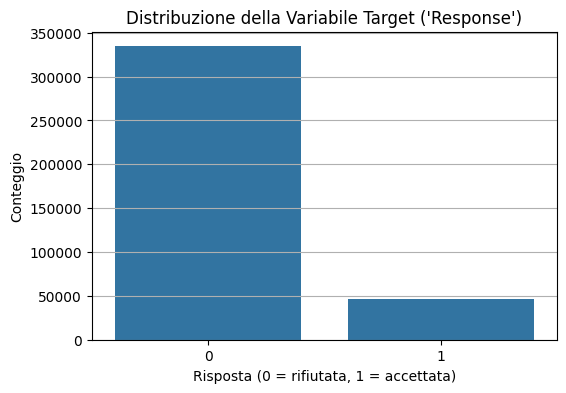

In [ ]:
#Distribution var target response
plt.figure(figsize=(6,4))
sns.countplot(x='Response', data=df)
plt.title("Distribuzione della Variabile Target ('Response')")
plt.xlabel("Risposta (0 = rifiutata, 1 = accettata)")
plt.ylabel("Conteggio")
plt.grid(axis='y')
plt.show()

In [ ]:
# Numerical check of the target variable distribution
# Check numerically if the classes are imbalanced
response_counts = df["Response"].value_counts()
print("\nDistribuzione numerica della variabile 'Response':")
print(response_counts)

# Percentages of refusals and acceptances
print(f"Percentuale di rifiuti: {response_counts[0] / response_counts.sum() * 100:.2f}%")
print(f"Percentuale di accettazioni: {response_counts[1] / response_counts.sum() * 100:.2f}%")


Distribuzione numerica della variabile 'Response':
Response
0    334399
1     46710
Name: count, dtype: int64
Percentuale di rifiuti: 87.74%
Percentuale di accettazioni: 12.26%


Come anticipato, nel processo di esplorazione preliminare è stata analizzata la distribuzione della variabile target Response, sia graficamente tramite un countplot, sia numericamente attraverso il conteggio e il calcolo delle percentuali di ciascuna classe.
Dall’output è emerso che il dataset presenta un forte sbilanciamento: l’87,74% dei clienti ha rifiutato l’offerta di cross-sell (Response = 0), mentre solo il 12,26% l’ha accettata (Response = 1).

I modelli predittivi potrebbero tendere a privilegiare la classe maggioritaria, trascurando i casi positivi di reale interesse per il business. Per questo motivo, nelle fasi successive è stata posta attenzione alla gestione dello sbilanciamento.

In [ ]:
# Descriptive statistics of Annual_Premium grouped by Response
df.groupby('Response')[['Annual_Premium']].describe()


Annual_Premium                                                        \
                  count          mean           std     min      25%      50%   
Response                                                                        
0              334399.0  30419.160276  16998.293197  2630.0  24351.0  31504.0   
1               46710.0  31604.092742  18646.508040  2630.0  24868.0  33002.0   

                             
              75%       max  
Response                     
0         39120.0  540165.0  
1         41297.0  540165.0

Le statistiche descrittive di Annual_Premium, calcolate separatamente per ciascuna classe della variabile target, indicano che i clienti che hanno accettato l’offerta di cross-sell hanno in media un premio annuale leggermente più alto (31.604 €) rispetto a quelli che l’hanno rifiutata (30.419 €). Anche i valori di mediana (33.002 € vs 31.504 €) e quartile superiore (41.297 € vs 39.120 €) sono più elevati nei clienti propensi all’acquisto. Tuttavia, la differenza non appare marcata e in entrambi i gruppi sono presenti outlier importanti (max = 540.165 €). Questo suggerisce che, pur con una leggera tendenza positiva, il solo importo del premio potrebbe non essere un predittore forte della risposta.

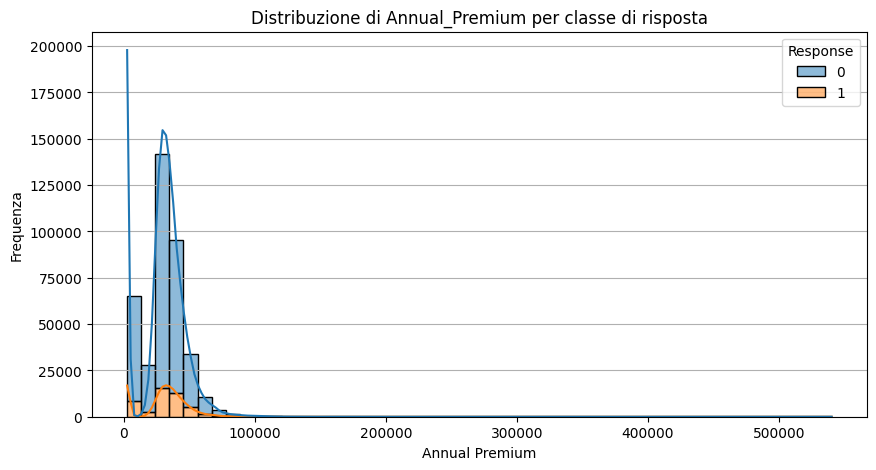

In [ ]:
# Annual Premium distribution

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="Annual_Premium", hue="Response", kde=True, bins=50, multiple="stack")
plt.title("Distribuzione di Annual_Premium per classe di risposta")
plt.xlabel("Annual Premium")
plt.ylabel("Frequenza")
plt.grid(axis='y')
plt.show()


Costruendo il grafico di distribuzione del premio annuale, si nota che vi sono pochissimi clienti con premi molto elevati (>200.000), visibili nella lunga coda destra.

Si construisce dunque lo stesso grafico ma escludendo i valori estremi.

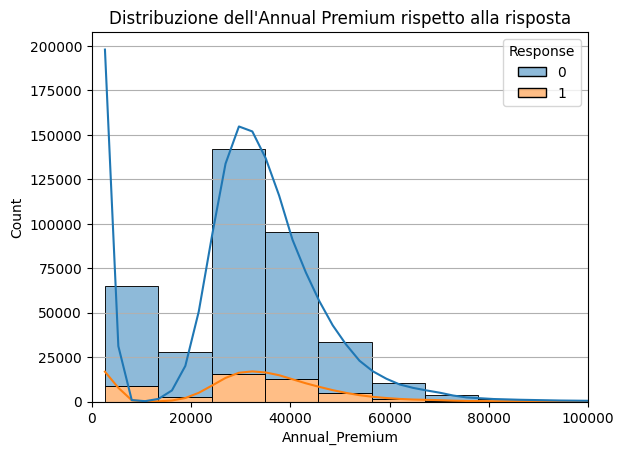

In [ ]:
# Annual_premium distribution excluding extreme outliers

sns.histplot(data=df, x='Annual_Premium', hue='Response', kde=True, bins=50, multiple='stack')
plt.title("Distribuzione dell'Annual Premium rispetto alla risposta")
plt.xlim(0, 100000)
plt.grid(axis='y')
plt.show()


la maggior parte dei clienti ha un premio inferiore a 50.000.
La classe degli interessati ha una concentrazione più marcata intorno ai 20.000–40.000.


### Distribuzione Età del veicolo rispetto alla risposta

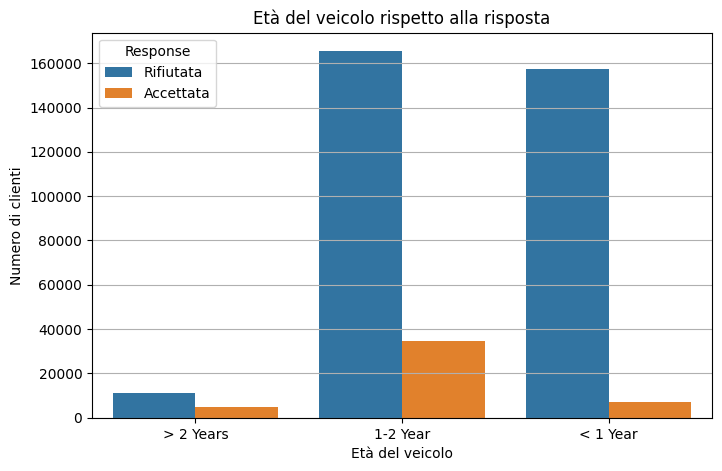

In [ ]:
# Distribution of Vehicle Age with respect to Response

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Vehicle_Age', hue='Response')
plt.title("Età del veicolo rispetto alla risposta")
plt.xlabel("Età del veicolo")
plt.ylabel("Numero di clienti")
plt.legend(title="Response", labels=["Rifiutata", "Accettata"])
plt.grid(axis='y')
plt.show()

In [ ]:
# Tabella incrociata Vehicle_Age vs Response
vehicle_age_response = pd.crosstab(df['Vehicle_Age'], df['Response'])

print(vehicle_age_response)


Response          0      1
Vehicle_Age               
1-2 Year     165510  34806
< 1 Year     157584   7202
> 2 Years     11305   4702


In [ ]:
vehicle_age_response_percent = (vehicle_age_response.div(vehicle_age_response.sum(axis=1), axis=0) * 100).round(2)

print(vehicle_age_response_percent)

Response         0      1
Vehicle_Age              
1-2 Year     82.62  17.38
< 1 Year     95.63   4.37
> 2 Years    70.63  29.37


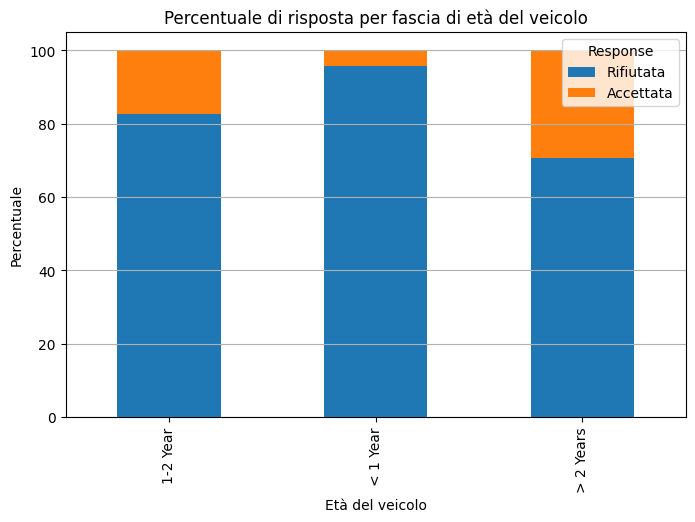

In [ ]:
# Distribution of Vehicle Age with respect to Response
vehicle_age_response_percent.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Percentuale di risposta per fascia di età del veicolo")
plt.ylabel("Percentuale")
plt.xlabel("Età del veicolo")
plt.legend(title="Response", labels=["Rifiutata", "Accettata"])
plt.grid(axis='y')
plt.show()

L’analisi della variabile Vehicle_Age rispetto alla risposta all’offerta di cross-sell mostra che la maggior parte dei clienti possiede veicoli con meno di 2 anni di anzianità, in particolare 200.316 clienti possieodno veicoli con 1–2 anni (gruppo più numeroso in termini assoluti, ma con propensione relativa inferiore rispetto a quella dei clienti con veicoli più datati).

In termini percentuali, i clienti con veicoli più vecchi di 2 anni mostrano il tasso di accettazione più elevato (29.37%), seguiti da quelli con veicoli tra 1 e 2 anni (17.38%). Al contrario, i clienti con veicoli molto recenti (< 1 anno) risultano i meno interessati, con un’accettazione pari al 4.37%. 


### Distribuzione Percentuale di risposta al cross-sell per Assicurazione Precedente

In [ ]:
# Absolute table
prev_ins_response = pd.crosstab(df['Previously_Insured'], df['Response'])

# Percentage table
prev_ins_response_percent = (prev_ins_response.div(prev_ins_response.sum(axis=1), axis=0) * 100).round(2)

# Merge the two tables into a single DataFrame
combined = prev_ins_response.astype(str) + " (" + prev_ins_response_percent.astype(str) + "%)"

# Visualization
print("Distribuzione Assoluta e Percentuale di Response per Previously_Insured:")
print(combined)

Distribuzione Assoluta e Percentuale di Response per Previously_Insured:
Response                          0               1
Previously_Insured                                 
0                   159929 (77.45%)  46552 (22.55%)
1                   174470 (99.91%)     158 (0.09%)


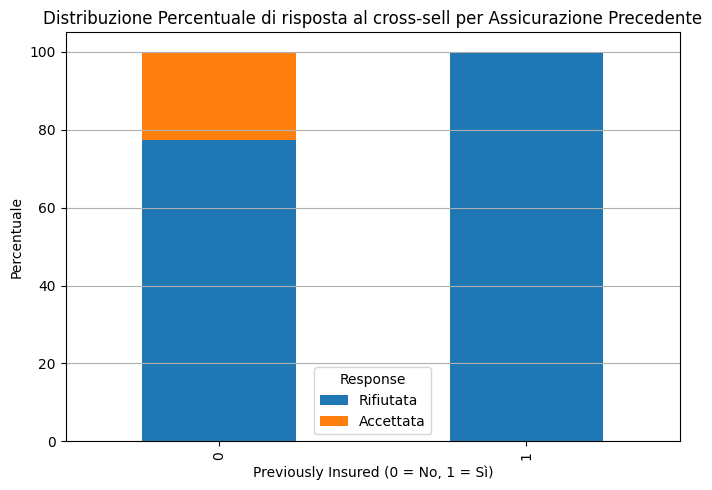

In [ ]:
# stacked bar of percentages

prev_ins_response_percent.plot(kind='bar', stacked=True, figsize=(7, 5))
plt.title("Distribuzione Percentuale di risposta al cross-sell per Assicurazione Precedente")
plt.xlabel("Previously Insured (0 = No, 1 = Sì)")
plt.ylabel("Percentuale")
plt.legend(title="Response", labels=["Rifiutata", "Accettata"])
plt.grid(axis='y')
plt.tight_layout()
plt.show()




L’analisi della variabile Previously_Insured mostra una marcata differenza nel tasso di risposta all’offerta di cross-sell tra i due gruppi.
I clienti non già assicurati per un veicolo mostrano una propensione all’accettazione del 22.55%, mentre tra i clienti già assicurati la percentuale scende drasticamente allo 0.09%.

Questa variabile risulta dunque altamente discriminante: il fatto di possedere già una copertura assicurativa per il veicolo è fortemente associato al rifiuto dell’offerta.


### EDA variabili categoriche non osservate precedentemente

### Distribuzione del sesso rispetto alla risposta

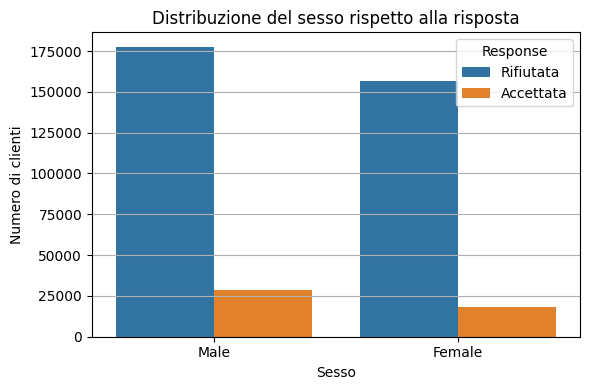

In [ ]:
# Countplot

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Gender', hue='Response')
plt.title("Distribuzione del sesso rispetto alla risposta")
plt.xlabel("Sesso")
plt.ylabel("Numero di clienti")
plt.legend(title="Response", labels=["Rifiutata", "Accettata"])
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [ ]:
# Calcolo delle percentuali di risposta per ciascun genere
gender_response_percent = (
    df.groupby('Gender')['Response']
    .value_counts(normalize=True)
    .unstack()
    .round(2) * 100
)

print("Percentuali di risposta per genere (in %):")
print(gender_response_percent)

Percentuali di risposta per genere (in %):
Response     0     1
Gender              
Female    90.0  10.0
Male      86.0  14.0


### Distribuzione dei danni al veicolo

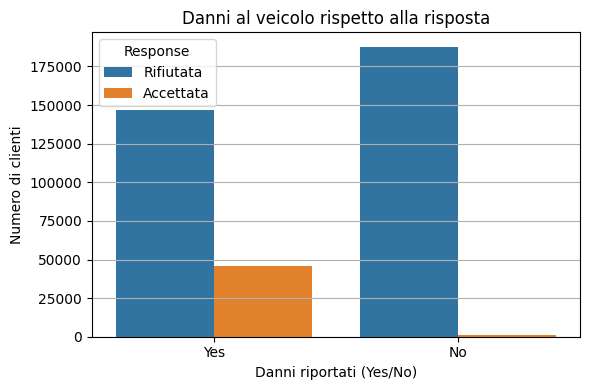

In [ ]:
# Countplot of Vehicle Damage with respect to Response

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Vehicle_Damage', hue='Response')
plt.title("Danni al veicolo rispetto alla risposta")
plt.xlabel("Danni riportati (Yes/No)")
plt.ylabel("Numero di clienti")
plt.legend(title="Response", labels=["Rifiutata", "Accettata"])
plt.grid(axis='y')
plt.tight_layout()
plt.show()



In [ ]:
# Response percentages by Vehicle_Damage group
damage_response_percent = (
    df.groupby('Vehicle_Damage')['Response']
    .value_counts(normalize=True)
    .unstack()
    .round(2) * 100
)

print("Percentuali di risposta per presenza di danni al veicolo (in %):")
print(damage_response_percent)

Percentuali di risposta per presenza di danni al veicolo (in %):
Response           0     1
Vehicle_Damage            
No              99.0   1.0
Yes             76.0  24.0


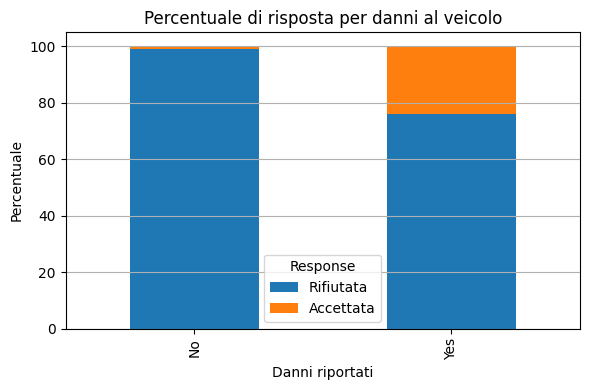

In [ ]:
# Convert to stacked bar chart format
damage_response_percent.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title("Percentuale di risposta per danni al veicolo")
plt.xlabel("Danni riportati")
plt.ylabel("Percentuale")
plt.legend(title="Response", labels=["Rifiutata", "Accettata"])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Infine, dalle ultime due analisi esplorative emerge che:

- La proporzione di clienti che accettano l’offerta di cross-selling è leggermente più alta tra gli uomini (14%) rispetto alle donne (10%).
- La variabile Vehicle_Damage risulta invece fortemente discriminante. I clienti che hanno riportato danni al veicolo mostrano un tasso di accettazione del 24%, nettamente superiore rispetto all’1% di chi non ha subito danni.



### MATRICE DI CORRELAZIONE

Per analizzare la relazione lineare tra le variabili numeriche presenti nel dataset, è stata costruita una matrice di correlazione. Prima di procedere, si sono effettuati alcuni passaggi di preprocessing:

- Rimozione dell’ID: la colonna id è stata eliminata in quanto identificatore univoco privo di significato predittivo;

- Codifica delle variabili categoriche ordinali e binarie:
Vehicle_Age è stata mappata in ordine crescente (< 1 Year → 0, 1-2 Year → 1, > 2 Years → 2),
Gender è stato codificato come Male = 1 e Female = 0,
Vehicle_Damage è stato trasformato in Yes = 1, No = 0

In [ ]:
#Drop the unique ID as it not useful for the model
df = df.drop("id", axis=1)


In [ ]:
#encoding
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})


# Gender: 'Male' → 1, 'Female' → 0
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Vehicle_Damage: 'Yes' → 1, 'No' → 0
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})


In [ ]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


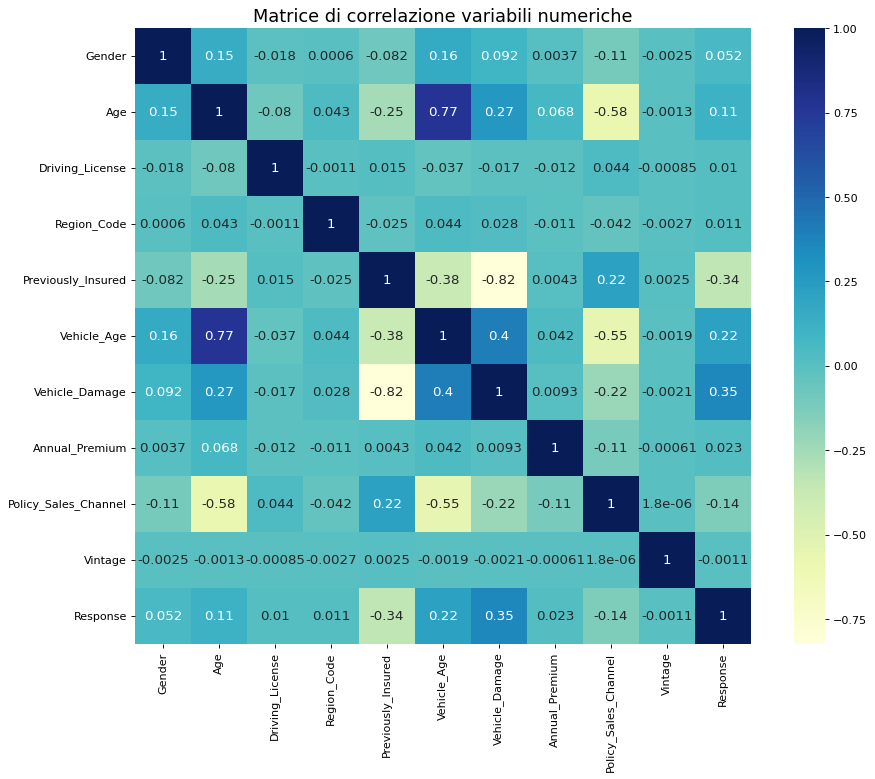

In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Correlation Matrix
corr_matrix = df[numerical_cols].corr()

# Plot della heatmap
plt.figure(figsize=(14, 10), dpi=80)

hm = sns.heatmap(corr_matrix,
                 cbar=True,
                 square=True,
                 yticklabels=corr_matrix.columns,
                 xticklabels=corr_matrix.columns,
                 annot=True,
                 cmap="YlGnBu",
                 annot_kws={'size':12})

plt.title('Matrice di correlazione variabili numeriche', size=16)
plt.show()

Osservazioni principali:
- Previously_Insured è la variabile con la correlazione negativa più marcata con la target Response (-0.34), riconfermando che chi possiede già un'assicurazione auto è molto meno propenso ad accettare l'offerta di cross-sell.
- Vehicle_Damage mostra una correlazione positiva con la target (0.35), confermando quanto già emerso dall’EDA: i clienti che hanno avuto danni al veicolo sono più inclini ad accettare la proposta.
- Vehicle_Age e Age presentano correlazioni più deboli ma comunque positive (rispettivamente 0.22 e 0.11) con Response.
- Le restanti variabili, come Annual_Premium o Vintage, hanno correlazioni molto basse con la variabile target.


La matrice conferma che Previously_Insured, Vehicle_Damage e in parte Vehicle_Age rappresentano le variabili numeriche più informative per il modello. 



### Preprocessing

In questa fase viene effettuata la separazione tra variabili indipendenti e variabile target, passaggio preliminare per l’addestramento del modello:

- La variabile target viene isolata nel vettore y.
- Tutte le restanti colonne, contenenti le informazioni descrittive dei clienti, costituiscono la matrice delle caratteristiche X.

In [ ]:
# Split betwen independent variables (X) and target (y)
X = df.drop('Response', axis=1)
y = df['Response']


Dopo la separazione vengono espezionati velocemente i dati per verificare la correttezza del preprocessing.

In [ ]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,44,1,28.0,0,2,1,40454.0,26.0,217
1,1,76,1,3.0,0,1,0,33536.0,26.0,183
2,1,47,1,28.0,0,2,1,38294.0,26.0,27
3,1,21,1,11.0,1,0,0,28619.0,152.0,203
4,0,29,1,41.0,1,0,0,27496.0,152.0,39


In [ ]:
X.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')

### Train/Test split

Il dataset è stato suddiviso in un training set (70%) per addestrare il modello ed un test set (30%) usato nella fase di valutazione per misurare la capacità del modello di generalizzare su nuovi dati mai visti. 

Sono state create due copie (X_train_dt, X_test_dt) che verranno utilizzate successivamente con altri modelli, in particolare con l’albero decisionale, per evitare conflitti con le trasformazioni specifiche applicate alla regressione logistica.

Prima di standardzzare le variabili continue sono state escluse quelle binarie, come Gender o Previously_Insured.
La standardizzazione è servita per portare tutte le feature su scala comparabile e migliorare la stabilità numerica della regressione logistica.

Infine, è stato addestrato un modello di Logistic Regression con l’argomento class_weight="balanced" per compensare lo sbilanciamento della variabile target. Questo parametro consente al modello di dare maggiore peso alla classe minoritaria (Response = 1) durante l’ottimizzazione della funzione di costo.


In [ ]:
# perform train test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.3, 
                                                    random_state=42,
                                                    stratify=y) #proportion between classes 

In [ ]:
# Create copies of the training and test sets 
# to use with the Decision Tree model

X_train_dt = X_train.copy()
X_test_dt = X_test.copy()

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(266776, 10) (266776,)
(114333, 10) (114333,)


In [ ]:
# Define the binary (0/1) variables that should be excluded from standardization
binary_vars = ['Previously_Insured', 'Vehicle_Damage', 'Driving_License', 'Response', 'Gender']

# Select only continuous variables 
continuous_vars = [col for col in df.columns if col not in binary_vars]

# Initialize the StandardScaler
ss = StandardScaler()

# Fit and transform the continuous variables in the training set
X_train[continuous_vars] = ss.fit_transform(X_train[continuous_vars])

# Apply the same transformation to X_test
X_test[continuous_vars] = ss.transform(X_test[continuous_vars])

In [ ]:
lr = LogisticRegression(class_weight="balanced")

# Train the model on the data
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

### Valutazione del Modello


Per valutare la stabilità e la capacità di generalizzazione del modello, è stata applicata una procedura di cross-validation stratificata a 10 fold. Questa tecnica consiste nel suddividere il training set in 10 sottogruppi (fold), utilizzando a rotazione 9 fold per l’addestramento e 1 per la validazione, ripetendo il processo 10 volte.
La stratificazione assicura che ciascun fold mantenga la stessa proporzione tra le classi.

In [ ]:
# Perform 10-fold cross-validation to evaluate the model’s generalization stability

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Compute the F1-score for each fold using the training set
scores_lr = cross_val_score(lr, X_train, y_train, cv=cv, scoring='f1')


Per ogni iterazione è stato calcolato l’F1-score. 

In questo progetto, l’obiettivo è identificare i clienti più propensi ad accettare un’offerta di cross-selling. In situazioni di questo tipo, in cui le classi sono sbilanciate, metriche comuni come l’accuracy possono risultare fuorvianti, poiché un modello che predice sempre la classe maggioritaria (rifiuto) otterrebbe comunque un’accuratezza elevata, pur fallendo nel riconoscere i clienti davvero interessati.

L’F1-score, invece, rappresenta il compromesso tra precisione (precision) e richiamo (recall), essendone la media armonica. 

In [ ]:
print(scores_lr)

# Print the average F1-score and its standard deviation across the folds
print(f"Logistic Regression - F1-score (CV 10-fold): {scores_lr.mean():.4f} ± {scores_lr.std():.4f}")

[0.39637064 0.39775141 0.40010043 0.40035053 0.39810308 0.39740955
 0.39795791 0.3989757  0.39847414 0.39814525]
Logistic Regression - F1-score (CV 10-fold): 0.3984 ± 0.0011


In [ ]:
print(scores_lr.mean())
print(scores_lr.std())

0.39836386472096524
0.0011352688624495437


Attraverso i valori ottenuti in ciascuna delle 10 iterazioni di cross-validation è possibile valutare la stabilità del modello. La media degli F1-score è pari a 0.0466, con una deviazione standard di 0.0439, evidenziando una certa instabilità nelle prestazioni predittive del modello (il momdello non generalizza bene).

### Calcolo delle Probabilità

Dopo l’addestramento del primo modello, è stata effettuata la predizione delle probabilità di appartenenza alla classe positiva per ciascun cliente. Queste probabilità sono poi confrontate con una soglia decisionale per trasformarle in una previsione binaria. 
Come primo approccio è stata adottata inizialmente la soglia standard di 0.5: se la probabilità stimata supera 0.5, il cliente viene classificato come "interessato alla proposta di cross-sell", altrimenti no. 

In [ ]:
#Compute probabilities for class Response = 1
y_proba_train = lr.predict_proba(X_train)[:, 1]
y_proba_test = lr.predict_proba(X_test)[:, 1]

#classification with treshold o.5
y_pred_train = (y_proba_train >= 0.5).astype(int)
y_pred_test = (y_proba_test >= 0.5).astype(int)



In [ ]:
# print first 10 prediction
print("Prime 10 predizioni sul test set (classe prevista):")
print(y_pred_test[:10])

# print first 10 prob for class 1 
print("Prime 10 probabilità di appartenere alla classe positiva (Response = 1):")
print(y_proba_test[:10])

Prime 10 predizioni sul test set (classe prevista):
[0 1 0 0 0 0 0 0 0 0]
Prime 10 probabilità di appartenere alla classe positiva (Response = 1):
[0.00432335 0.59023438 0.00413685 0.00622484 0.17836184 0.00366477
 0.02317565 0.00358203 0.00347023 0.00358164]


In [ ]:
# compare predictions, probabilities and actual values 


results = pd.DataFrame({
    'y_true': y_test[:10].values,
    'y_proba': y_proba_test[:10],
    'y_pred': y_pred_test[:10]
})

print("Confronto tra valore reale, probabilità stimata e classe predetta (prime 10 righe):")
print(results)

Confronto tra valore reale, probabilità stimata e classe predetta (prime 10 righe):
   y_true   y_proba  y_pred
0       0  0.004323       0
1       0  0.590234       1
2       0  0.004137       0
3       0  0.006225       0
4       0  0.178362       0
5       0  0.003665       0
6       0  0.023176       0
7       0  0.003582       0
8       0  0.003470       0
9       0  0.003582       0


### Classification Report e Matrice di Confusione

Sono stati analizzati gli output del modello con altre due soglie di classificazione oltre alla standard: 0.3 e 0.25.
Si è abbassata la soglia per valutare l'effetto sui falsi negativi.


In [ ]:
# report threshold 0.5
print("TRAIN REPORT - threshold 0.5")
print(classification_report(y_train, y_pred_train))   #training set first
print("TEST REPORT - threshold 0.5")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT - threshold 0.5
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    234079
           1       0.25      0.98      0.40     32697

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

TEST REPORT - threshold 0.5
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100320
           1       0.25      0.98      0.40     14013

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



<Figure size 600x400 with 0 Axes>

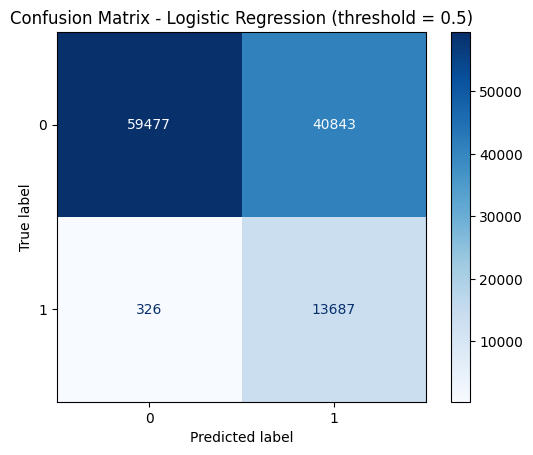

In [ ]:
#confusion matrix threshold = 0.5
cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Logistic Regression (threshold = 0.5)")
plt.grid(False)
plt.show()


In [ ]:
# try different thresholds

y_pred_train = np.where(y_proba_train >= 0.3, 1, 0)
y_pred_test = np.where(y_proba_test >= 0.3, 1, 0)

print("TRAIN REPORT - threshold 0.3")
print(classification_report(y_train, y_pred_train))

print("TEST REPORT - threshold 0.3")
print(classification_report(y_test, y_pred_test))


TRAIN REPORT - threshold 0.3
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    234079
           1       0.25      0.98      0.40     32697

    accuracy                           0.63    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.63      0.70    266776

TEST REPORT - threshold 0.3
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    100320
           1       0.25      0.98      0.40     14013

    accuracy                           0.63    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.63      0.70    114333



In [ ]:
# lower threshold to reduce false negatives compared to false positives
# a customer wrongly classified as uninterested is more costly than the opposite

y_pred_train = np.where(y_proba_train >= 0.25, 1, 0)
y_pred_test = np.where(y_proba_test >= 0.25, 1, 0)

print("TRAIN REPORT - threshold 0.25")
print(classification_report(y_train, y_pred_train))

print("TEST REPORT - threshold 0.25")
print(classification_report(y_test, y_pred_test))


TRAIN REPORT - threshold 0.25
              precision    recall  f1-score   support

           0       1.00      0.57      0.73    234079
           1       0.24      0.98      0.39     32697

    accuracy                           0.62    266776
   macro avg       0.62      0.78      0.56    266776
weighted avg       0.90      0.62      0.69    266776

TEST REPORT - threshold 0.25
              precision    recall  f1-score   support

           0       1.00      0.57      0.73    100320
           1       0.24      0.99      0.39     14013

    accuracy                           0.62    114333
   macro avg       0.62      0.78      0.56    114333
weighted avg       0.90      0.62      0.69    114333



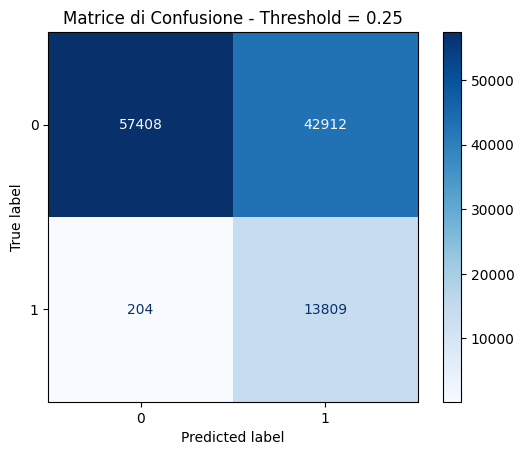

In [ ]:
# Prediction - threshold 0.25
y_pred_test_025 = (y_proba_test >= 0.25).astype(int)

# Prediction - threshold 0.30
y_pred_test_030 = (y_proba_test >= 0.30).astype(int)

# confusion matrix - threshold 0.25
cm_025 = confusion_matrix(y_test, y_pred_test_025)

disp_025 = ConfusionMatrixDisplay(confusion_matrix=cm_025, display_labels=[0, 1])
disp_025.plot(cmap="Blues", values_format='d')
plt.title("Matrice di Confusione - Threshold = 0.25")
plt.grid(False)
plt.show()

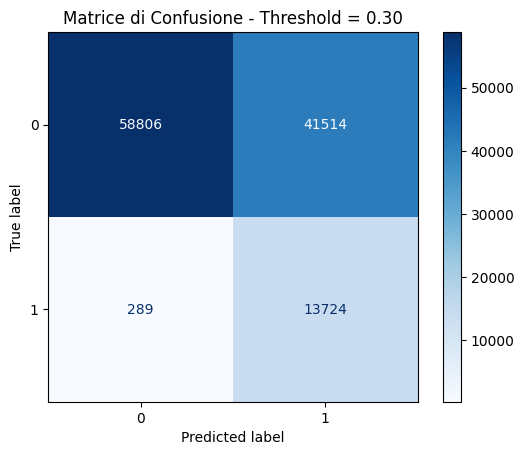

In [ ]:
#confusion matrix - threshold 0.3
cm_030 = confusion_matrix(y_test, y_pred_test_030)

disp_030 = ConfusionMatrixDisplay(confusion_matrix=cm_030, display_labels=[0, 1])
disp_030.plot(cmap="Blues", values_format='d')
plt.title("Matrice di Confusione - Threshold = 0.30")
plt.grid(False)
plt.show()

Riducendo progressivamente la soglia da 0.5 a 0.3 e poi 0.25, si osserva un lieve miglioramento del recall per la classe 1 (fino a 0.99), a discapito della precisione, che cala di un punto a 0.24. Questo comportamento riflette una maggiore propensione del modello a classificare i clienti come interessati, accettando un numero più elevato di falsi positivi pur di ridurre i falsi negativi.

Nella matrice di confusione a soglia 0.5, i falsi negativi erano 326, mentre con la soglia 0.25 scendono a 204. Sebbene il calo sia di “solo” un centinaio di casi, questa differenza può risultare strategicamente rilevante in un contesto di cross-selling, dove è preferibile contattare anche clienti non interessati piuttosto che perdere una potenziale vendita. 

La soglia 0.25 appare quella più adatta.

In [ ]:
# Calculate % false positives
print(round((42907 / 100320) * 100, 2))


42.77


In percentuale questo si traduce con il 42,75% dei clienti non interessati erroneamente classificato come interessato. Ma come già detto, è un compromesso accettabile: il costo di un falso positivo è contenuto (ad esempio l’invio di una mail), mentre quello di un falso negativo è molto più alto.

### ROC Curve

L’analisi della curva ROC (Receiver Operating Characteristic) fornisce una valutazione visiva della capacità del modello di distinguere tra clienti interessati apparenenti ad una delle due classi.


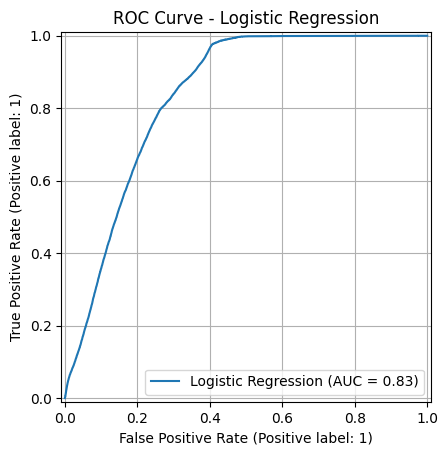

AUC (Area Under the Curve): 0.8343


In [ ]:
RocCurveDisplay.from_estimator(lr, X_test, y_test, name="Logistic Regression")


plt.title("ROC Curve - Logistic Regression")
plt.grid(True)
plt.show()

# Compute and print AUC
auc = roc_auc_score(y_test, y_proba_test)
print(f"AUC (Area Under the Curve): {auc:.4f}")

La curva mostra un’AUC pari a 0.83, segno di una buona capacità del classificatore nel distinguere tra clienti.

### Curva di Apprendimento

La curva di apprendimento serve a valutare come si comporta il modello man mano che cresce la dimensione del training set, permettendo di individuare eventuali segnali di overfitting o underfitting.

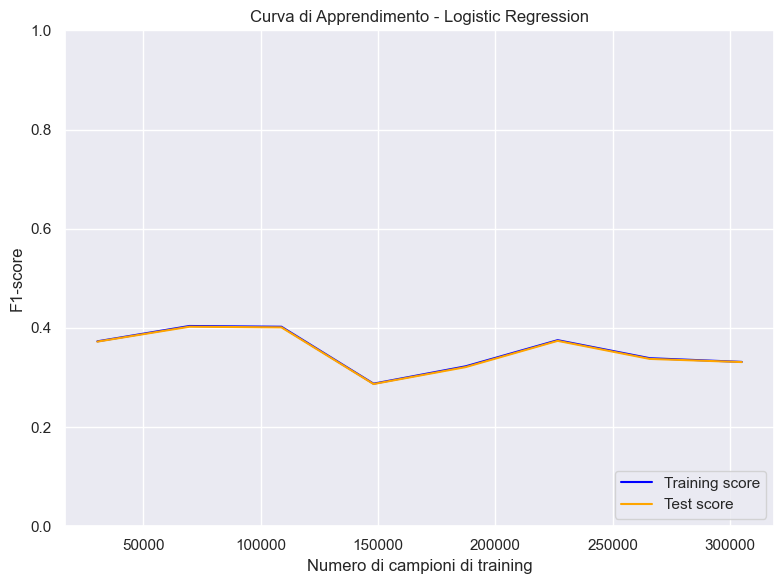

In [ ]:
from sklearn.model_selection import learning_curve

sns.set_theme()

# Compute training and validation scores for different training set sizes
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=lr,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring='f1',
    n_jobs=-1
)


plt.figure(figsize=(8, 6))
plt.plot(train_sizes_abs, train_scores.mean(axis=1), label="Training score", color="blue")# Plot the mean training score
plt.plot(train_sizes_abs, test_scores.mean(axis=1), label="Test score", color="orange")# Plot the mean validation (test) score
plt.ylim([0, 1])
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score")
plt.title("Curva di Apprendimento - Logistic Regression")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Nel nostro caso, le curve di F1-score per training e test set sono molto vicine, suggerendo che il modello generalizza in modo coerente e non è soggetto a overfitting. Tuttavia, i valori di F1-score rimangono contenuti (tra 0.33 e 0.40 circa), segnalando che la regressione logistica non riesce a cogliere appieno i pattern del problema e risulta troppo semplice.



Per valutare se un diverso approccio al bilanciamento delle classi potesse migliorare le performance predittive del modello, è stato testato anche l’oversampling tramite la tecnica di RandomOverSampler. In particolare, il training set è stato sovracampionato in modo da equilibrare il numero di osservazioni tra le due classi. Dopo la standardizzazione delle variabili, il modello di Logistic Regression è stato addestrato sul dataset sovracampionato e successivamente testato sul set originale di test. Le performance ottenute, in termini di recall e f1-score, sono risultate molto simili a quelle ottenute con il metodo class_weight="balanced". Tuttavia, l’oversampling ha comportato un aumento del tempo computazionale e una maggiore complessità del flusso di lavoro, senza apportare un miglioramento significativo alle metriche. Per questo motivo, si è scelto di non integrare l’oversampling nel modello finale, mantenendo come approccio definitivo il bilanciamento tramite class_weight="balanced", più efficiente e già efficace nel gestire lo sbilanciamento della variabile target.

### MODELLI ALTERNATIVI



### Albero Decisionale

Dopo aver testato la regressione logistica, si passa alla costruzione di un modello alternativo: l’albero decisionale. Questo tipo di algoritmo consente di catturare in modo più diretto relazioni non lineari e interazioni tra le variabili.

In una fase iniziale, l’albero decisionale era stato addestrato senza limitazioni sui parametri di complessità. Con la costruzione della curva di apprendimento è emerso un forte overfitting: il modello raggiungeva un F1-score pari a 1.0 sul training set e non riusciva a generalizzare correttamente sui dati di test, modellando anche il rumore presente nei dati di addestramento.

Per risolvere questo problema, sono stati introdotti specifici vincoli di regolarizzazione:
- max_depth=10 per limitare la profondità dell’albero ed evitare che apprenda pattern troppo specifici;
- min_samples_split=20 per impedire la suddivisione di nodi poco rappresentativi;
- min_samples_leaf=10 per assicurare che ogni foglia contenga un numero minimo di osservazioni.


Il modello è stato poi addestrato sul training set originale (non standardizzato), e sono state calcolate le probabilità di appartenenza alla classe positiva sul test set.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


In [ ]:
# def model decision tree
dt = DecisionTreeClassifier(
    max_depth=10,              # limits the maximum depth to 10
    min_samples_split=20,      # a node splits only if it has at least 20 samples
    min_samples_leaf=10,       # each leaf must have at least 10 samples
    random_state=42,
    class_weight='balanced' )

In [ ]:
# train 
dt.fit(X_train_dt, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

In [ ]:
# Cross-validation on Decision Tree
# Stratified K-Fold to maintain class balance
# Stratified K-Fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation on the unscaled dataset
scores_dt = cross_val_score(dt, X_train_dt, y_train, cv=cv, scoring='f1')

# Results
print(f"Decision Tree - F1-score (CV 10-fold): {scores_dt.mean():.4f} ± {scores_dt.std():.4f}")

Decision Tree - F1-score (CV 10-fold): 0.4240 ± 0.0028


In [ ]:
print(scores_dt.mean())
print(scores_dt.std())

0.42395291182142936
0.0028400779714948454


Anche per l’albero decisionale è stata eseguita una cross-validation stratificata a 10 fold, ottenendo un F1-score medio di 0.4240 con una deviazione standard molto contenuta (± 0.0028). Rispetto alla regressione logistica (F1 ≈ 0.0466), il decision tree mostra prestazioni superiori.

In [ ]:
#prediction prob on test set
y_proba_test_dt = dt.predict_proba(X_test_dt)[:, 1]

Per coerenza anche per l’albero decisionale è stato scelto di valutare le prestazioni del modello utilizzando direttamente una soglia di classificazione pari a 0.25.

In [ ]:
#classification with threshold 0.25
threshold = 0.25
y_pred_test_dt = (y_proba_test_dt >= threshold).astype(int)


In [ ]:
#classification report
print(f"CLASSIFICATION REPORT dt (threshold = o.25")
print(classification_report(y_test, y_pred_test_dt))

CLASSIFICATION REPORT dt (threshold = o.25
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100320
           1       0.25      0.98      0.40     14013

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



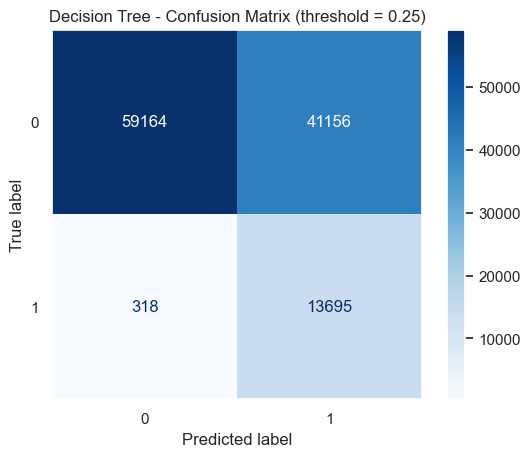

In [ ]:
# confusion matrix decision tree model
cm_dt = confusion_matrix(y_test, y_pred_test_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Decision Tree - Confusion Matrix (threshold = {threshold})")
plt.grid(False)
plt.show()

Dalla matrice di confusione emergono risultati molto simili a quelli osservati con la regressione logistica: il numero di falsi negativi pari a 318. Anche in questo caso, il modello sacrifica la precisione (0.25) per mantenere un recall elevato (0.99), riducendo così il rischio di perdere clienti interessati.

L’accuracy complessiva è del 64%, con un F1-score della classe 1 pari a 0.40. Sebbene le metriche puntuali siano comparabili tra i due modelli, come visto precedentemente la validazione incrociata evidenzia una maggiore stabilità e capacità predittiva complessiva per l’albero decisionale, che mostra un F1-score medio più elevato (0.4240 vs 0.0466) e una deviazione standard più bassa.

L’albero decisionale risulta più affidabile in fase di generalizzazione.

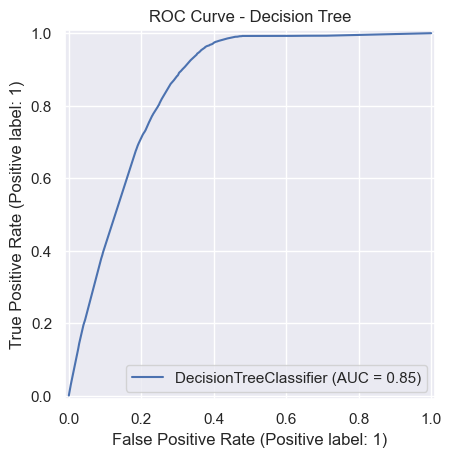

In [ ]:
#roc curve
RocCurveDisplay.from_estimator(dt, X_test_dt, y_test)
plt.title("ROC Curve - Decision Tree")
plt.grid(True)
plt.show()

La curva ROC del modello ad albero decisionale mostra un’ottima capacità discriminativa, con un AUC pari a 0.85.

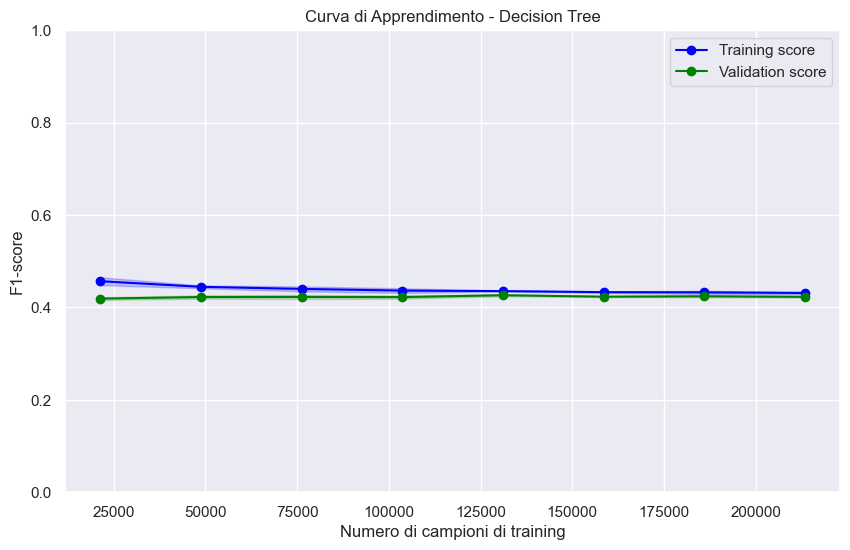

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=dt,
    X=X_train_dt,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring='f1',
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.2, color='blue')
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color='green')

plt.title("Curva di Apprendimento - Decision Tree")
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score")
plt.grid(True)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

Come anticipato in fase di definizione del modello, il training iniziale senza parametri di regolarizzazione portava a un adattamento eccessivo ai dati. 
Ora invece la curva di apprendimento mostra un comportamento migliore: e prestazioni sul training set non sono più perfette, e le curve di training e validation risultano allineate, segno che l’overfitting è stato contenuto.

Le due curve sono piatte (l'umentare il numero di campioni non produce miglioramenti sostanziali nelle prestazioni) e tendono a stabilizzarsi intorno a un F1-score di circa 0.43 (il modello potrebbe non essereabbastanza complesso per cogliere tutte le relazioni nei dati, oppure che le variabili disponibili non siano sufficientemente informative). 

Il modello è stabile, ma non particolarmente potente. Sarà quindi opportuno valutare, in fasi successive, l’uso di modelli più sofisticati come ensemble methods (es. Random Forest).




### Confronto tra i due modelli 

Dopo aver analizzato separatamente le performance della regressione logistica e dell’albero decisionale, si propone un confronto diretto tra i due modelli attraverso la curva ROC.

Nel codice, sono stati calcolati i valori di False Positive Rate (FPR) e True Positive Rate (TPR) per ciascun modello tramite la funzione roc_curve, mentre il valore dell’AUC (Area Under the Curve) è stato ottenuto con roc_auc_score. Le curve risultanti sono state poi tracciate sullo stesso grafico per facilitare il confronto.

In [ ]:
#AUC
auc_lr = roc_auc_score(y_test, y_proba_test)         # Logistic Regression
auc_dt = roc_auc_score(y_test, y_proba_test_dt)

In [ ]:
from sklearn.metrics import roc_curve

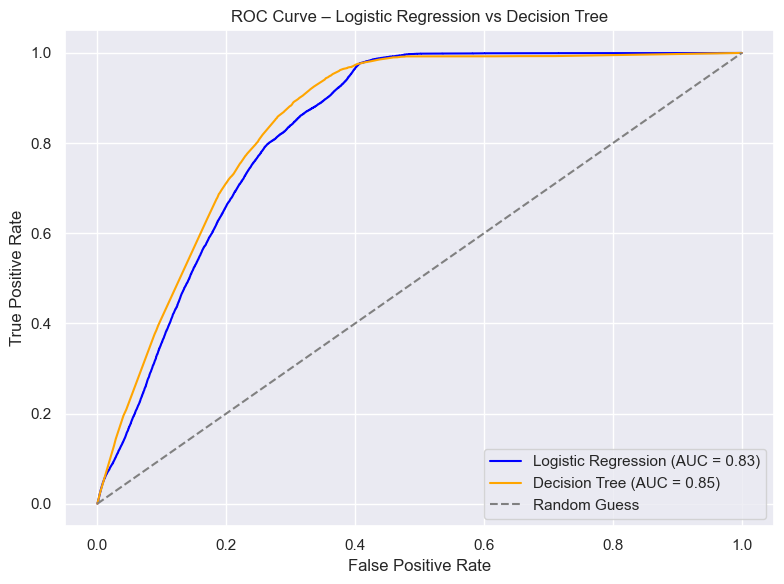

In [ ]:

# FPR, TPR e AUC for both models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_test)
auc_lr = roc_auc_score(y_test, y_proba_test)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_test_dt)
auc_dt = roc_auc_score(y_test, y_proba_test_dt)

# Plot the ROC curves of both models to visually compare their classification performance
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})", color='blue')
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")

plt.title("ROC Curve – Logistic Regression vs Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Il grafico mostra chiaramente il comportamento dei modelli in termini di compromesso tra TPR e FPR. Entrambi si collocano ben al di sopra della diagonale casuale, confermando una buona capacità discriminativa. Tuttavia, il modello ad albero decisionale presenta una curva leggermente più vicina all’angolo in alto a sinistra.

Indicatori chiave (AUC):
- Decision Tree: AUC = 0.85
- Logistic Regression: AUC = 0.83

### Conslusione e Considerazioni finali

Sebbene entrambi i modelli mostrino prestazioni simili, l’albero decisionale appare leggermente più efficace nel contesto specifico, grazie a una migliore stabilità  e una maggiore capacità di catturare relazioni non lineari tra le variabili.

Tuttavia, questo vantaggio rimane contenuto. Alla luce di quanto osservato, una naturale estensione dell’analisi potrebbe essere l’introduzione di un modello ensemble, come Random Forest, in grado di mitigare il bias residuo della Logistic Regression e la limitata capacità predittiva del singolo albero decisionale, sfruttando la combinazione di più modelli deboli per ottenere una classificazione più robusta e generalizzabile.